OVERVIEW:

In this tutorial notebook, we will be covering a simple approach to email classification(spam or not spam) using BERT

Steps are:
- We will load our data - mainly sentences and labels-span or not spam
- Load these in bert to generate an contextualized embedding vector of length 768

- - We will first apply preprocessing using the preprocessor object , refer the documentation

- - We will pass this preprocessed text to our model to generate the contexutailized embedding vector


- Finally pass this embedding vector to single neuron in output to do binary classificaton

- For maximizing performance we will be balancing our dataset and use a dropout layer to regularize the model and prevent overfitting

# Loading Dependencies

Includes
- Tensorflow_hub : Place where all tenseorflow pretrained models are stored.
- Pandas : For data loading, manipulation and wrangling.
- Tensorflow_text : Allows addditional NLP text processing capablities outside scope of tensorflow
- Skelarn : For doing data evaluation and splitting
- Matplotlib : For visualization

In [54]:
import tensorflow_text as text
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Loading Data

- Read Data
- Display data
USING PANDAS

In [55]:
# load data
df_first = pd.read_csv('./spam_data.csv')

In [56]:
df_first.head()

,Unnamed: 0,target,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [57]:
# rearrange the columns
df_first.drop(columns=df_first.columns[0], axis=1, inplace=True)
df_first.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [58]:
# rename columns
df_first = df_first.rename({'target': 'Category', 'text': 'Message'}, axis=1)
df_first.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Analysis

- Check the description by grouping by category :
* no of data points for each category - count
* no of unique values in each category - unique




In [59]:
# check count and unique and top values and their frequency
df_first['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

**Clearly dataset is imbalanced - not so much but still it can affect our model. Need to use some type of regulariztion like downsampling dataset for mazority class**

# Downsampling Dataset 

**Includes:**
- Check percentage of unbalances.
- Creating 2 new dataframes out of existing one.
- Taking any random minority no of samples - `(747)` for majority class`(4825)`.
- Creating a balanced dataset by concating 2 new data frames.

In [60]:
# check percentange of data - states how much data needs to be balanced
str(round(747/4825,2))+'%'

'0.15%'

In [61]:
# creating 2 new dataframe as df_hm , df_spm

df_spm = df_first[df_first['Category']=='spam']
print("Spam Dataset Shape:", df_spm.shape)

df_hm = df_first[df_first['Category']=='ham']
print("Ham Dataset Shape:", df_hm.shape)

Spam Dataset Shape: (747, 2)
Ham Dataset Shape: (4825, 2)


In [62]:
# downsampling ham dataset - take only random 747 example
# will use df_spm.shape[0] - 747

df_hm_downsampled = df_hm.sample(df_spm.shape[0])
df_hm_downsampled.shape

(747, 2)

In [63]:
# concating both dataset - df_spm and df_hm_balanced to create df_balanced dataset
df_balanced = pd.concat([df_spm , df_hm_downsampled])
df_balanced.head()

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [64]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [65]:
df_balanced.sample(10)

,Category,Message
4968,spam,You can donate £2.50 to UNICEF's Asian Tsunami...
5567,spam,This is the 2nd time we have tried 2 contact u...
5112,spam,December only! Had your mobile 11mths+? You ar...
1214,ham,"Yeah, probably but not sure. Ilol let u know, ..."
2438,spam,For ur chance to win £250 cash every wk TXT: P...
3021,ham,I thank you so much for all you do with selfle...
5099,ham,"Ah, well that confuses things, doesnt it? I th..."
5456,spam,For the most sparkling shopping breaks from 45...
3097,ham,We walked from my moms. Right on stagwood pass...
2575,spam,Your next amazing xxx PICSFREE1 video will be ...


# Data Prepration



1. Create Numerical Repersentation Of Category - One hot encoding
* Create a new column
* Use `df[col].apply(lambda function)`
* Lambda Function - if spam return 1, else return 0 (for ham) - ternary operators : [`lambda x : value expression else value`]

In [66]:
# creating numerical repersentation of category - one hot encoding
df_balanced['spam'] = df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)

In [67]:
# displaying data - spam -1 , ham-0
df_balanced.sample(4)

,Category,Message,spam
4485,ham,Shopping? Eh ger i toking abt syd leh...Haha,0
5463,ham,U GOIN OUT 2NITE?,0
4311,spam,Someone U know has asked our dating service 2 ...,1
1227,spam,Reply with your name and address and YOU WILL ...,1


2. Do train-test split
* split dataset into 80-20 ratio with 80% train and remaing as test
* for eveness of data we will use `stratify` agrument which ensures same ratio of both category is loaded for each case, even if one categoy has more training samples - prevents overfitting 

Store our data in: 
- `X_train, y_train` - traininge set(training_data and labels respectively)
- `X_test,, y_test` - testing set(testing_data and labels)

In [68]:
# loading train test split
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'],
                                                    stratify = df_balanced['spam'])

In [70]:
# check for startification
y_train.value_counts()

0    560
1    560
Name: spam, dtype: int64

In [71]:
560/560

1.0

In [72]:
y_test.value_counts()

1    187
0    187
Name: spam, dtype: int64

In [73]:
187/187

1.0

***-> Almost similar, means data is downsampled now ***

# Model Creation 

Our Model is BERT , which will do 2 thing:
- Preporcess our training data that will be feeded - includes **adding additional token CLF , PAD and SEP** to genrate `input_mask`, `input_type_ids`, `input_word_ids(token given to each word in  sentences)` 

* Note: no of words in sentence - 128/ max length of sentence can be 128

## Downloading BERT

Model specification : 
- Layers - 12
- Hidden layers - 768 - embedding size
- Attention - 12
Name - Bert Small
---
This model has 2 parts:
- Bert_preprocessor - preprocess the text to be BERT ready
- Bert_encoder - do the actual encoding
---
Steps:
> Preprocessor
* create a keras hub layer from the preprocessing url 

> Encoder
* create a keras hub layer from the encoder/ model url

Awesome functionality provided by Tf hub API


                            +

Creating our own model using functional model api- link old layers to new layers rather than building it(in a sequential way) and allows sharing of layers too

Info:
- Text the embedding as input - text_input
- Create a Sinlge output dense layer
- Add dropout to reduce overfitting

In [74]:
# downloading preprocessing files and model
bert_pre_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_enc_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_preprocessor = hub.KerasLayer(bert_pre_url)
bert_encoder = hub.KerasLayer(bert_enc_url)

2022-07-09 11:05:12.641495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Process And Encode Data

Use functional API to process and encode data in the layers itself

- Create a input layers with shape() , type - tf.string, and layer name - text - `TEXT_INPUT`

- Pass TEXT_INPUT into bert_prerocessor - `PREPROCESSED TEXT[*]`
- Pass the above[*] to encoder - `EMBEED`
- pass pooled_outputs of EMBEED to dropout layer - `DROPOUT`
- create a dense layer with activation as `sigmoid` `OUTPUTS`
- Create out MODEL (inputs - text_input, outputs - dropout) 

In [75]:
import tensorflow as tf

In [76]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [77]:
# check summary of model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['Inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

##  Compiling model

- Optimizer - ADAM
- Loss - binary_crossentropy
- metrics - accuracy , precesion and recall

In [78]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [79]:
#@title Optional 
# optional - defining tensorflow callbacks
import tensorflow as tf
import datetime
%load_ext tensorboard

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


##  Training Model
- Recomended to use `GPU` - providing so many training data

- We traing our model on training set
- For 10 epochs only - so model don't overfit - given enough training data

In [80]:
# %tensorboard --logdir logs/fit

In [81]:
with tf.device('/cpu:0'):
    history = model.fit(X_train, y_train, epochs = 1 , callbacks = [tensorboard_callback])

2022-07-09 11:05:39.005846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 138s 4s/step - loss: 0.5979 - accuracy: 0.6938 - precision: 0.6867 - recall: 0.7125


# Model Evaluation 

- Evaulating model performance 
using `model.evaluate(X_test, y_test)`

- Predicting X_test - `y_pred`
-- Checking its values as 1 or 0 
- Getting Confusion matrix
-- Flattening y_pred 
-- Ploting consufion matrix

- Getting classification report 

In [82]:
with tf.device('/cpu:0'):
    # Evaluating performace
    model.evaluate(X_test,y_test)

2022-07-09 11:07:52.359050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 37s 3s/step - loss: 0.5225 - accuracy: 0.8476 - precision: 0.8571 - recall: 0.8342


In [83]:
with tf.device('/cpu:0'):
    # getting y_pred by predicting over X_text and flattening it
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten() # require to be in one dimensional array , for easy maniputation

2022-07-09 11:08:28.850675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 37s 3s/step


In [84]:
# checking the results y_pred
import numpy as np

y_pred = np.where(y_pred>0.5,1,0 )
y_pred 

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,

**Not so understandable so plotting confusion matrix and classification report  for good visualization**

In [85]:
# importing consfusion maxtrix
from sklearn.metrics import confusion_matrix , classification_report

In [86]:
# creating confusion matrix 
cm = confusion_matrix(y_test,y_pred)
cm

array([[161,  26],
       [ 31, 156]])

In [87]:
# plotting as graph - importing seaborn
import seaborn as sns

Text(33.0, 0.5, 'Actual')

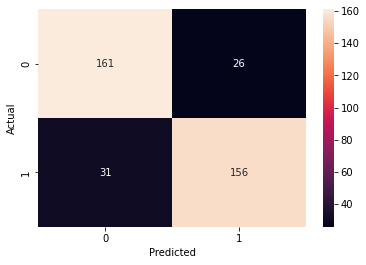

In [88]:
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [89]:
# printing classification report
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       187
           1       0.86      0.83      0.85       187

    accuracy                           0.85       374
   macro avg       0.85      0.85      0.85       374
weighted avg       0.85      0.85      0.85       374



**Good Precesion And Recall Score, but can be improved** 

# Model Prediction

- We will be predicting data on text coprus,
value > 5 is most likely be `spam`

In [90]:
predict_text = [
                # Spam
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest', 
                'Netflix is sending you a refund of $12.99. Please reply with your bank account and routing number to verify and get your refund', 
                'Your account is temporarily frozen. Please log in to to secure your account ', 

                #ham
                'The article was published on 18th August itself',
                'Although we are unable to give you an exact time-frame at the moment, I would request you to stay tuned for any updates.',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
]

In [91]:
with tf.device('/cpu:0'):
    test_results = model.predict(predict_text)

2022-07-09 11:09:06.550396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [92]:
output = np.where(test_results>0.5,'spam', 'ham') 

In [93]:
output

array([['ham'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['ham'],
       ['ham']], dtype='<U4')

# Additional Content

- Create a function which will take in `sentece array` and return the embedding vector for entire sentece -`pooled_output`
---
STEPS:
To do so inside the we follow 3 steps:

1. We `pass the sentence array to bert_preprocessor` as it can act a function point and name it **preprocessed_text**

2. Now we `pass this preprocessed sentence into encoder` and it return a embedding vector dictonary 

3. We retun only the `pooled output` as we are interested in only the entire sentence encoding

---
Later we compare the embedding vector using `cosine - similarity from sklearn.metrics.parwiase` class


In [94]:
def get_embedding(sentence_arr):
    'takes in sentence array and return embedding vector'
    preprocessed_text = bert_preprocessor(sentence_arr)
    embeddings = bert_encoder(preprocessed_text)['pooled_output']
    return embeddings

In [95]:
with tf.device('/cpu:0'):
    e = get_embedding([
                'We’d all like to get a $10,000 deposit on our bank accounts out of the blue, but winning a prize—especially if you’ve never entered a contest',
                'The image you sent is a UI bug, I can check that your article is marked as regular and is not in the monetization program.'
    ])

2022-07-09 11:09:07.745461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 11:09:07.838499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [96]:
# load similartiy score
from sklearn.metrics.pairwise import cosine_similarity

In [97]:
# check similarity score
print(f'Similarity score between 1st sentence(spam) and second sentence(spam) : {cosine_similarity([e[0]] , [e[1]])}')

Similarity score between 1st sentence(spam) and second sentence(spam) : [[0.85391974]]


* Not exact similarity, may show un expected results as can be seen - they are somewhat similar but its false as spam and actual can't be same